#$\bf{f(t) = a_0 + \sum_{n=1}^{\infty} a_n cos(\frac{2n\pi t}{T}) + \sum_{n=1}^{\infty} b_n sin(\frac{2n\pi t}{T})}$


In [1]:
import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 18})
plt.style.use('seaborn')



# statics

In [2]:
startdatum = "2016-01-01"
enddatum = "2019-10-10"

custom_date_parser = lambda x: datetime.strptime(x, "%d.%m.%Y")

mypath = "C:/Temp/Trading/ETFS/python/analysis/"
df = pd.read_csv(mypath + "VIX.csv",sep=";",decimal=',',
                            parse_dates=True,date_parser=custom_date_parser,
                            index_col=0)



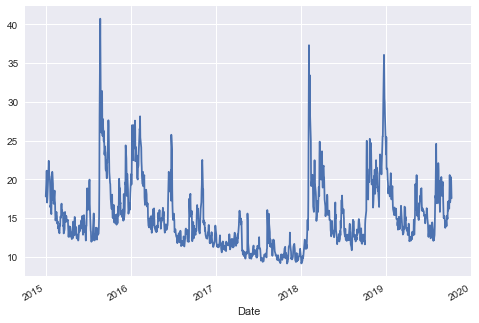

In [3]:
df=df.sort_index()
df=df.truncate(before=startdatum)
df=df.truncate(after=enddatum)

df
df.index[:-1]
df["Close"].plot()

In [4]:
#df["Close"].plot()
df[:10]

df_np =df["Close"].to_numpy()
signal = df_np
print(type(df_np))

#print(signal)
signal_clean = signal

minsignal, maxsignal = signal.min(), signal.max()

<class 'numpy.ndarray'>


## Compute Fourier Transform

In [5]:
n = len(df_np)
dt = 1.0/n
t = np.arange(0, 1, dt)

fhat = np.fft.fft(signal, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq =  np.arange(n) #frequency array
#freq = (1/(dt*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index
len(t)

1202

## Filter out noise

In [6]:
threshold = 80
psd_idxs = psd > threshold #array of 0 and 1
psd_clean = psd * psd_idxs #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

## Visualization

C:\Users\r889990\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


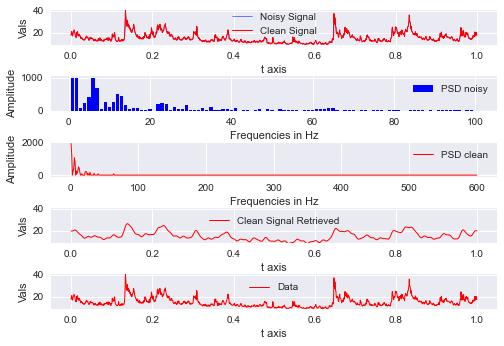

In [8]:
freqmax = 100
maxamp = 1000

psd = np.clip(psd,0,maxamp)

fig, ax = plt.subplots(5,1)
ax[0].plot(t, signal, color='b', lw=0.5, label='Noisy Signal')
ax[0].plot(t, signal_clean, color='r', lw=1, label='Clean Signal')
ax[0].set_ylim([minsignal, maxsignal])
ax[0].set_xlabel('t axis')
ax[0].set_ylabel('Vals')
ax[0].legend()

ax[1].bar(freq[idxs_half][:freqmax], np.abs(psd[idxs_half][:freqmax]), color='b', lw=0.5, label='PSD noisy')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(freq[idxs_half], np.abs(psd_clean[idxs_half]), color='r', lw=1, label='PSD clean')
ax[2].set_xlabel('Frequencies in Hz')
ax[2].set_ylabel('Amplitude')
ax[2].legend()

ax[3].plot(t, signal_filtered, color='r', lw=1, label='Clean Signal Retrieved')
ax[3].set_ylim([minsignal, maxsignal])
ax[3].set_xlabel('t axis')
ax[3].set_ylabel('Vals')
ax[3].legend()

ax[4].plot(t, df["Close"], color='r', lw=1, label='Data')
ax[4].set_ylim([minsignal, maxsignal])
ax[4].set_xlabel('t axis')
ax[4].set_ylabel('Vals')
ax[4].legend()


plt.subplots_adjust(hspace=0.9)
plt.savefig('signal-analysis.png', bbox_inches='tight', dpi=300)
